In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM
%store -r Y_motion_CoM
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(12870, 28)
(12870, 2)


In [6]:
X_motion_CoM[0]

array([0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184, 0.133, -0.34, 0.186, -0.133,
       -0.34, -0.277, 0.133, -0.342, -0.277, -0.133, -0.342,
       2.06538830341e-06, -7.40856241332e-09, -1.98321098827e-44,
       -4.91923108558e-23, 2.46110009701e-23, -0.00656005589676, True,
       False, 0, 0], dtype=object)

In [7]:
Y_motion_CoM[0]

array([0.004316108424438636, -0.00044173166939715696], dtype=object)

# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Predict CoM (x) movement

In [9]:
X_motion_CoM[0, :]

array([0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184, 0.133, -0.34, 0.186, -0.133,
       -0.34, -0.277, 0.133, -0.342, -0.277, -0.133, -0.342,
       2.06538830341e-06, -7.40856241332e-09, -1.98321098827e-44,
       -4.91923108558e-23, 2.46110009701e-23, -0.00656005589676, True,
       False, 0, 0], dtype=object)

In [10]:
Y_motion_CoM[0, :]

array([0.004316108424438636, -0.00044173166939715696], dtype=object)

### Linear Regression

In [11]:
# Input
#X = np.hstack((X_motion_CoM[:, :2], 
#               np.array([X_motion_CoM[:, 6]]).T,
#               np.array([X_motion_CoM[:, 9]]).T,
#               np.array([X_motion_CoM[:, 12]]).T,
#               np.array([X_motion_CoM[:, 15]]).T))

X = np.hstack((X_motion_CoM[:, :2], 
               np.array([X_motion_CoM[:, 5]]).T,
               X_motion_CoM[:, 6:8],
               X_motion_CoM[:, 9:11],
               X_motion_CoM[:, 12:14],
               X_motion_CoM[:, 15:17],
               X_motion_CoM[:, 18:20],
               np.array([X_motion_CoM[:, 23]]).T,
               X_motion_CoM[:, 24:26],
               #X_motion_CoM[:, 26:28]))
               np.array([X_motion_CoM[:, 26]]).T))

# Labels
Y = np.array([Y_motion_CoM[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8651882528387813
RMSE:  0.01323904439322575
The lowest error is:  1.4168189956201976e-06
The highest error is:  0.11427529545487286
The avg. error is:  0.00747145648951902


In [17]:
model_fr_com_x.coef_

array([[ 1.14402016e-01, -1.46263600e-04, -9.49649521e-03,
         1.04827938e+00, -4.08979242e-02, -1.17332787e-01,
         1.28137632e-01, -6.63037331e-02, -1.08698563e-01,
         2.30694608e-01,  1.45460953e-01]])

In [18]:
model_fr_com_x.intercept_

array([-0.07340656])

Text(0, 0.5, 'Predictions')

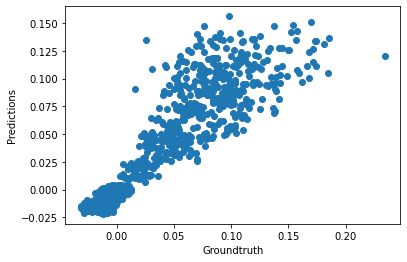

In [12]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [41]:
%store model_fr_com_x

Stored 'model_fr_com_x' (LinearRegression)


In [42]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [43]:
# Save model
joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav']

## Predict CoM (y) movement

### Linear Regression

In [13]:
# Input
#X = np.hstack((X_motion_CoM[:, :2], 
#               np.array([X_motion_CoM[:, 6]]).T,
#               np.array([X_motion_CoM[:, 9]]).T,
#               np.array([X_motion_CoM[:, 12]]).T,
#               np.array([X_motion_CoM[:, 15]]).T))
X = np.hstack((X_motion_CoM[:, :2], 
               np.array([X_motion_CoM[:, 5]]).T,
               X_motion_CoM[:, 6:8],
               X_motion_CoM[:, 9:11],
               X_motion_CoM[:, 12:14],
               X_motion_CoM[:, 15:17],
               X_motion_CoM[:, 18:20],
               np.array([X_motion_CoM[:, 23]]).T,
               X_motion_CoM[:, 24:26],
               #X_motion_CoM[:, 26:28]))
               np.array([X_motion_CoM[:, 27]]).T))

# Label matrix which consists only of
# the next x coordinate of the FR foot.
# We dont consider the first row.
Y = np.array([Y_motion_CoM[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.885521990356486
RMSE:  0.013018753743473454
The lowest error is:  1.0251443478270783e-06
The highest error is:  0.06860701017619084
The avg. error is:  0.008348581563638177


In [23]:
model_fr_com_y.coef_

array([[-0.00441734,  0.01496484,  0.01807551, -0.10798794,  1.49287406,
        -0.12222931, -0.25313078,  0.11289323, -0.20699757,  0.16328088,
         0.13514436]])

In [29]:
model_fr_com_y.intercept_

array([-0.06957352])

Text(0, 0.5, 'Predictions')

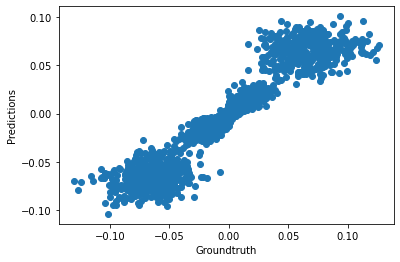

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [50]:
%store model_fr_com_y

Stored 'model_fr_com_y' (LinearRegression)


In [51]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [52]:
# Save model
joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav']